In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import glob
from typing import List
import scipy
from scipy import stats


## TRATAMENTO DE DADOS

#### Lendo o arquivo

In [2]:
df = pd.read_csv('houses_to_rent_v2.csv')

#### Explorando os dados

In [3]:
df.describe()

,area,rooms,bathroom,parking spaces,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
count,10692.000000,10692.000000,10692.000000,10692.000000,1.069200e+04,10692.000000,10692.000000,10692.000000,1.069200e+04
mean,149.217920,2.506079,2.236813,1.609147,1.174022e+03,3896.247194,366.704358,53.300879,5.490487e+03
std,537.016942,1.171266,1.407198,1.589521,1.559231e+04,3408.545518,3107.832321,47.768031,1.648473e+04
min,11.000000,1.000000,1.000000,0.000000,0.000000e+00,450.000000,0.000000,3.000000,4.990000e+02
25%,56.000000,2.000000,1.000000,0.000000,1.700000e+02,1530.000000,38.000000,21.000000,2.061750e+03
50%,90.000000,2.000000,2.000000,1.000000,5.600000e+02,2661.000000,125.000000,36.000000,3.581500e+03
75%,182.000000,3.000000,3.000000,2.000000,1.237500e+03,5000.000000,375.000000,68.000000,6.768000e+03
max,46335.000000,13.000000,10.000000,12.000000,1.117000e+06,45000.000000,313700.000000,677.000000,1.120000e+06


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   city                 10692 non-null  object
 1   area                 10692 non-null  int64 
 2   rooms                10692 non-null  int64 
 3   bathroom             10692 non-null  int64 
 4   parking spaces       10692 non-null  int64 
 5   floor                10692 non-null  object
 6   animal               10692 non-null  object
 7   furniture            10692 non-null  object
 8   hoa (R$)             10692 non-null  int64 
 9   rent amount (R$)     10692 non-null  int64 
 10  property tax (R$)    10692 non-null  int64 
 11  fire insurance (R$)  10692 non-null  int64 
 12  total (R$)           10692 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 1.1+ MB


Nenhum valor nulo. 

#### Floor: Object --> Int64

*floor* está definido como *Object*. Isso se deve ao fato de que, quando o andar do imóvel é o térro, esse dado é representado pela *string* "-".
Como se trata de um número discreto, vamos fazer o *casting*.


In [5]:
df = df.assign(floor = lambda x: x['floor'].str.replace('-', '0')\
          .astype('int64')).copy()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   city                 10692 non-null  object
 1   area                 10692 non-null  int64 
 2   rooms                10692 non-null  int64 
 3   bathroom             10692 non-null  int64 
 4   parking spaces       10692 non-null  int64 
 5   floor                10692 non-null  int64 
 6   animal               10692 non-null  object
 7   furniture            10692 non-null  object
 8   hoa (R$)             10692 non-null  int64 
 9   rent amount (R$)     10692 non-null  int64 
 10  property tax (R$)    10692 non-null  int64 
 11  fire insurance (R$)  10692 non-null  int64 
 12  total (R$)           10692 non-null  int64 
dtypes: int64(10), object(3)
memory usage: 1.1+ MB


#### Renomear colunas, substituindo espaços e parênteses por *underscore*. Remover eventuais espaços leading and trailing.

In [7]:
rename_dict = {c : c.replace(' (R$)', "").replace(" ", "_", 1).strip() for c in df.columns}
df.rename(columns=rename_dict, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   city            10692 non-null  object
 1   area            10692 non-null  int64 
 2   rooms           10692 non-null  int64 
 3   bathroom        10692 non-null  int64 
 4   parking_spaces  10692 non-null  int64 
 5   floor           10692 non-null  int64 
 6   animal          10692 non-null  object
 7   furniture       10692 non-null  object
 8   hoa             10692 non-null  int64 
 9   rent_amount     10692 non-null  int64 
 10  property_tax    10692 non-null  int64 
 11  fire_insurance  10692 non-null  int64 
 12  total           10692 non-null  int64 
dtypes: int64(10), object(3)
memory usage: 1.1+ MB


#### Remover espaços antes e depois dos dados das colunas *Object*.

In [9]:
def get_object_coluns(df) -> np.ndarray:
    """Get all columns whose dtype is Object from a pandas DataFrame

    Args:
        df (pd.DataFrame): Input pandas DataFrame to get object columns from.
    
    Returns:
        np.ndarray
    """
    return df.dtypes[df.dtypes == 'object'].index.values
    
    

In [10]:
def trim_object_columns(df: pd.DataFrame, column_names: np.ndarray|List[str]) -> pd.DataFrame:
    """Removes trim spaces from object type columns

    Args:
        df (pd.DataFrame): Pandas DataFrame.
        column_names (np.ndarray|List[str]): columns to be trimmed.

    Returns
    """
    for column in column_names:
        df[column] = df[column].str.strip().copy()

    return df
    

In [11]:
columns_object_type = get_object_coluns(df)
df = trim_object_columns(df, columns_object_type)

#### Verificando registros duplicados

Como não temos uma chave primária definida (nem mesmo uma surrogate key), vamos definir uma seguindo o critério abaixo:

Combinação dos valores de todas as colunas (chave primária composta). 

Caso haja dois ou mais registros cujos valores de todas as colunas sejam coincidentes, consideraremos como um registro duplicado.

In [12]:
summary_duplicated = pd.DataFrame([
        len(df) - np.sum(df.duplicated()),
        np.sum(df.duplicated())
], index=['unique', 'duplicated'], columns=['value'])

In [13]:
summary_duplicated

,value
unique,10334
duplicated,358


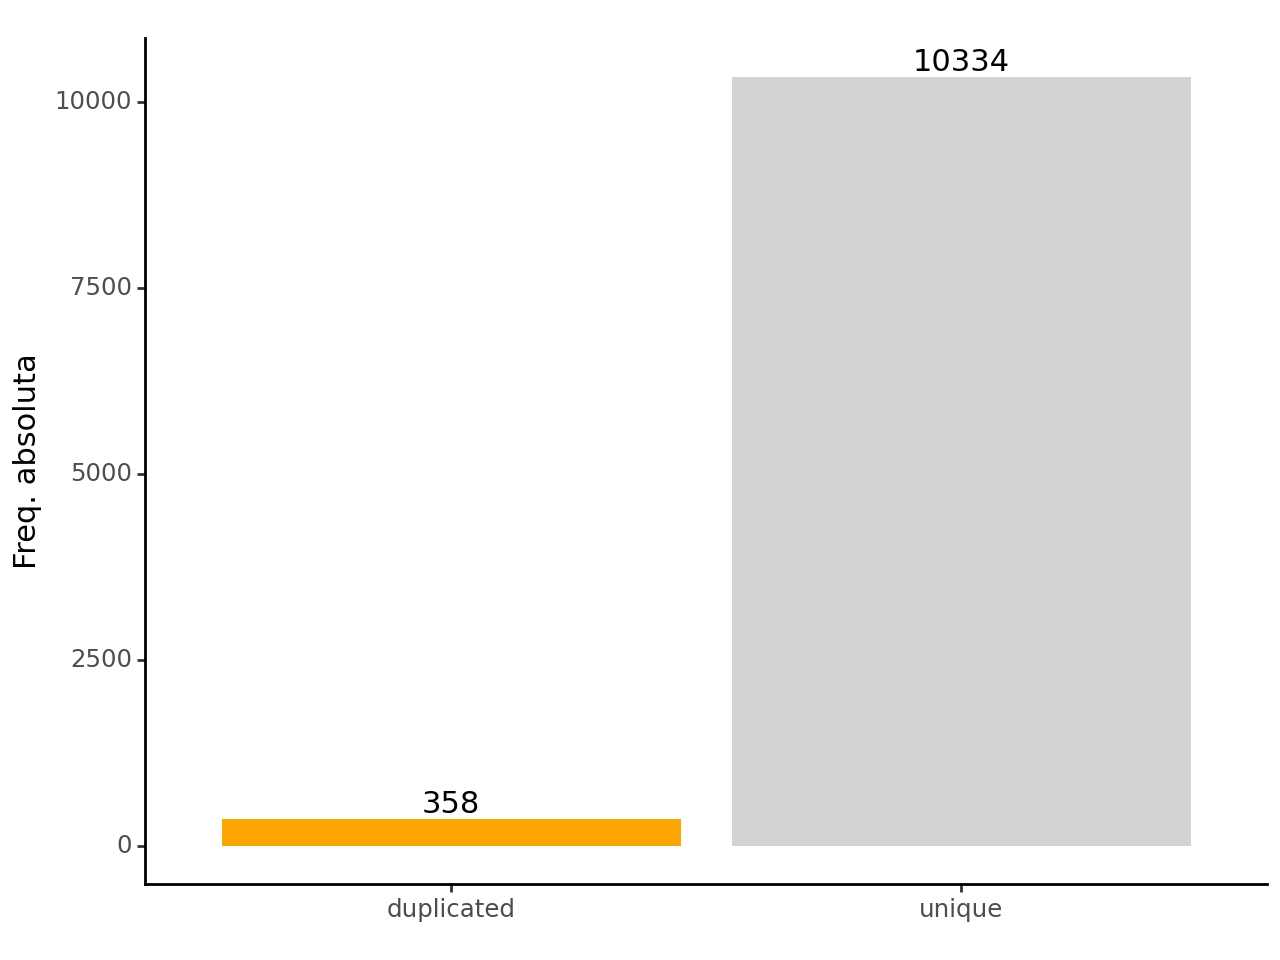

In [14]:
g=(
    ggplot(data=summary_duplicated)
    +geom_bar(
        stat='identity',
        mapping=aes(x=summary_duplicated.index,
           y=summary_duplicated['value']),
        fill=['orange', 'lightgrey']
    )
    +geom_text(data=summary_duplicated,
              mapping=aes(label='value', y='value', x=summary_duplicated.index), 
               stat='identity',
               va='bottom',
              )
    
    +labs(
        y='Freq. absoluta'
    )
    +theme_classic()
)

print(g)

#### Remover duplicados

In [15]:
df.drop_duplicates(inplace=True)

In [16]:
df.describe()

,area,rooms,bathroom,parking_spaces,floor,hoa,rent_amount,property_tax,fire_insurance,total
count,10334.000000,10334.000000,10334.000000,10334.000000,10334.000000,1.033400e+04,10334.000000,10334.000000,10334.000000,1.033400e+04
mean,152.439423,2.539965,2.268725,1.644475,5.100929,1.091244e+03,3966.296013,376.929263,54.264273,5.488943e+03
std,545.875595,1.168185,1.414650,1.598527,6.067906,1.144609e+04,3436.190007,3160.602165,48.164380,1.266911e+04
min,11.000000,1.000000,1.000000,0.000000,0.000000,0.000000e+00,450.000000,0.000000,3.000000,4.990000e+02
25%,59.000000,2.000000,1.000000,1.000000,1.000000,1.800000e+02,1598.250000,41.000000,21.000000,2.116000e+03
50%,95.000000,3.000000,2.000000,1.000000,3.000000,5.710000e+02,2750.000000,130.000000,37.000000,3.685500e+03
75%,190.000000,3.000000,3.000000,2.000000,8.000000,1.286750e+03,5000.000000,389.750000,70.000000,6.912000e+03
max,46335.000000,13.000000,10.000000,12.000000,301.000000,1.117000e+06,45000.000000,313700.000000,677.000000,1.120000e+06


#### Dados estranhos da tabela acima:

- Entender melhor a area 46335 $m^2$ de area parece estranho.
- A taxa de condominio (hoa_R\\$) $1.117 \times 10^6$ é mais alta que o alguel?
- O andar com valor 301 também não faz sentido.
- IPTU no valor de R\\$ 313.700.

Para entender melhor, vamos explorar com gráficos.

#### Entendendo melhor a área de 46.335 $m^2$

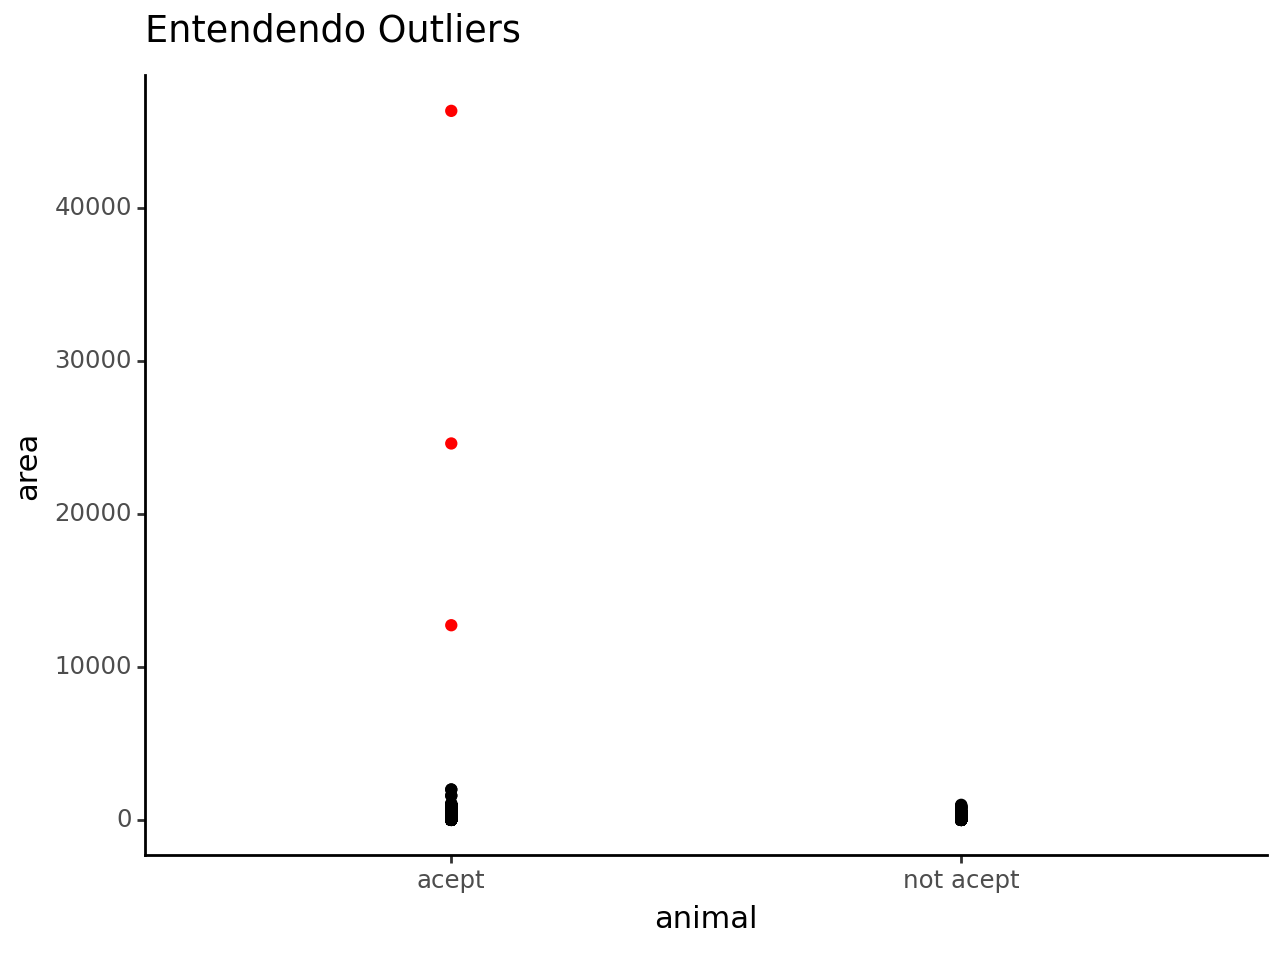

In [17]:
g=(
    ggplot(data=df)
    +geom_point(
        aes(x='animal', y='area'),
        fill=np.where(df.area > 10000, 'red', 'black'),
        color=np.where(df.area > 10000, 'red', 'black')
    )
    +theme_classic()
    +labs(
        title='Entendendo Outliers'
    )
)
print(g)

In [18]:
df.loc[df['area'] > 10000]

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,hoa,rent_amount,property_tax,fire_insurance,total
2397,Belo Horizonte,46335,4,8,5,11,acept,furnished,960,8500,646,114,10220
5915,São Paulo,24606,5,4,4,12,acept,not furnished,2254,8100,7859,103,18320
9241,Campinas,12732,3,2,0,3,acept,not furnished,700,1600,96,21,2417


#### Observações discrepantes

##### Area 46335 $m^2$

Acima, podemos notas que a área de 46.335 $m^2$ se refere à uma propriedade em Belo Horizonte. A priori, poderíamos interpretá-la como uma propriedade rural ou algo do gênero. Contudo, existe um dado de que tal propriedade está no andar 11.

##### Area 24.606 $m^2$

Em São Paulo, há um imóvel com área de 24.606 $mˆ2$. Aqui o caso é igual ao de Belo Horizonte. Além disso, o valor do IPTU (property_tax_R\\$) é bem acima quando comparado com os outros dois casos.

##### Área 12.732 $m^2$.

Aqui o imóvel está localizado em Campinas, interior do estado de São Paulo. Igualmente discrepante. Basicamente possui a metade da área da propriedade de São Paulo, mas com custo total igual 1/9 do valor daquela cidade. As principais diferenças ocorrem por conta dos valores do aluguel e IPTU, que são significativamente mais baratas que naquela cidade. Porém, tal diferença necessita ser checada na fonte dos dados.


#### Explorando a distribuição das áreas das propriedades, desconsiderando os *outliers* detectados acima.

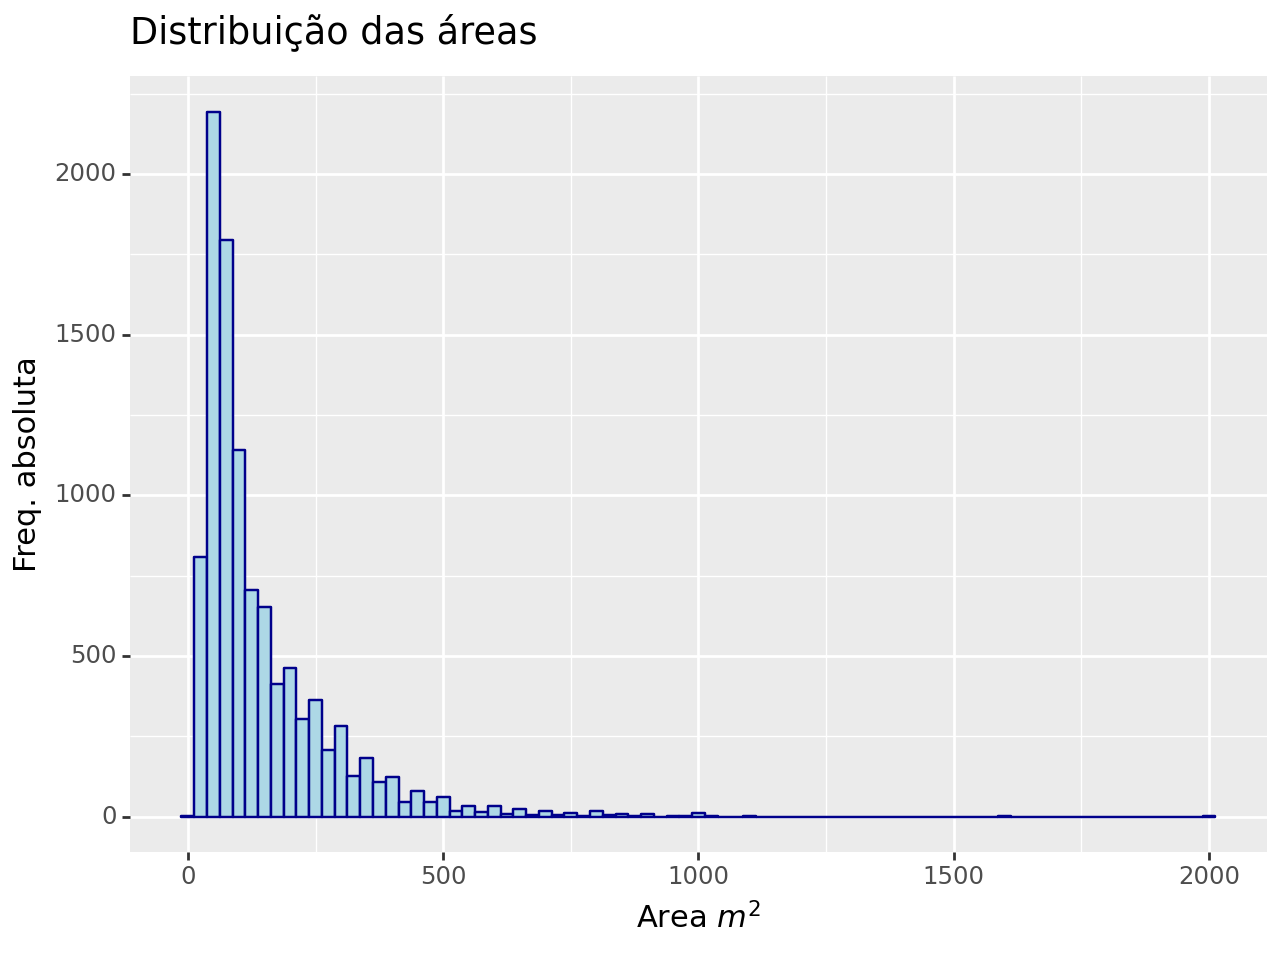

In [19]:
# Removendo outliers de area
df.query("area < 10000", inplace=True)

g=(
    ggplot(data=df)
    +geom_histogram(
        aes(x='area'),
        binwidth=25,
        color='darkblue',
        fill='lightblue'
    )
    +labs(
        y='Freq. absoluta',
        x='Area $m^2$',
        title='Distribuição das áreas',
    )
)
print(g)

#### Explorando a taxa de condomínio discrepante: R\\$ 1.117 $\times 10^6$

Nesse caso, estamos falando uma taxa de condomínio de mais de 1 milhão de reais. Não faz muito sentido. Se considerarmos o valor das demais *features*, como por exemplo, número de vagas de garagem, podemos supor que não faz sentido um apartamento de 155 $m^2$ sem vaga de garagem e a um preço tão alto de condomínio. 

Podemos faz algumas suposições baseadas em erro no valor: 

1. O valor corresponde, na verdade, ao valor de venda e foi erroneamente imputado ao valor do condomínio;
2. O valor foi erroneamente multiplicado por 1000. O condomínio seria no valor de R$ 1.117,00 mensais. 

In [20]:
df.loc[df['hoa'] == df['hoa'].max()]

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,hoa,rent_amount,property_tax,fire_insurance,total
255,Belo Horizonte,155,1,4,0,4,not acept,not furnished,1117000,2790,64,38,1120000


#### Verificando os valores de condomínio

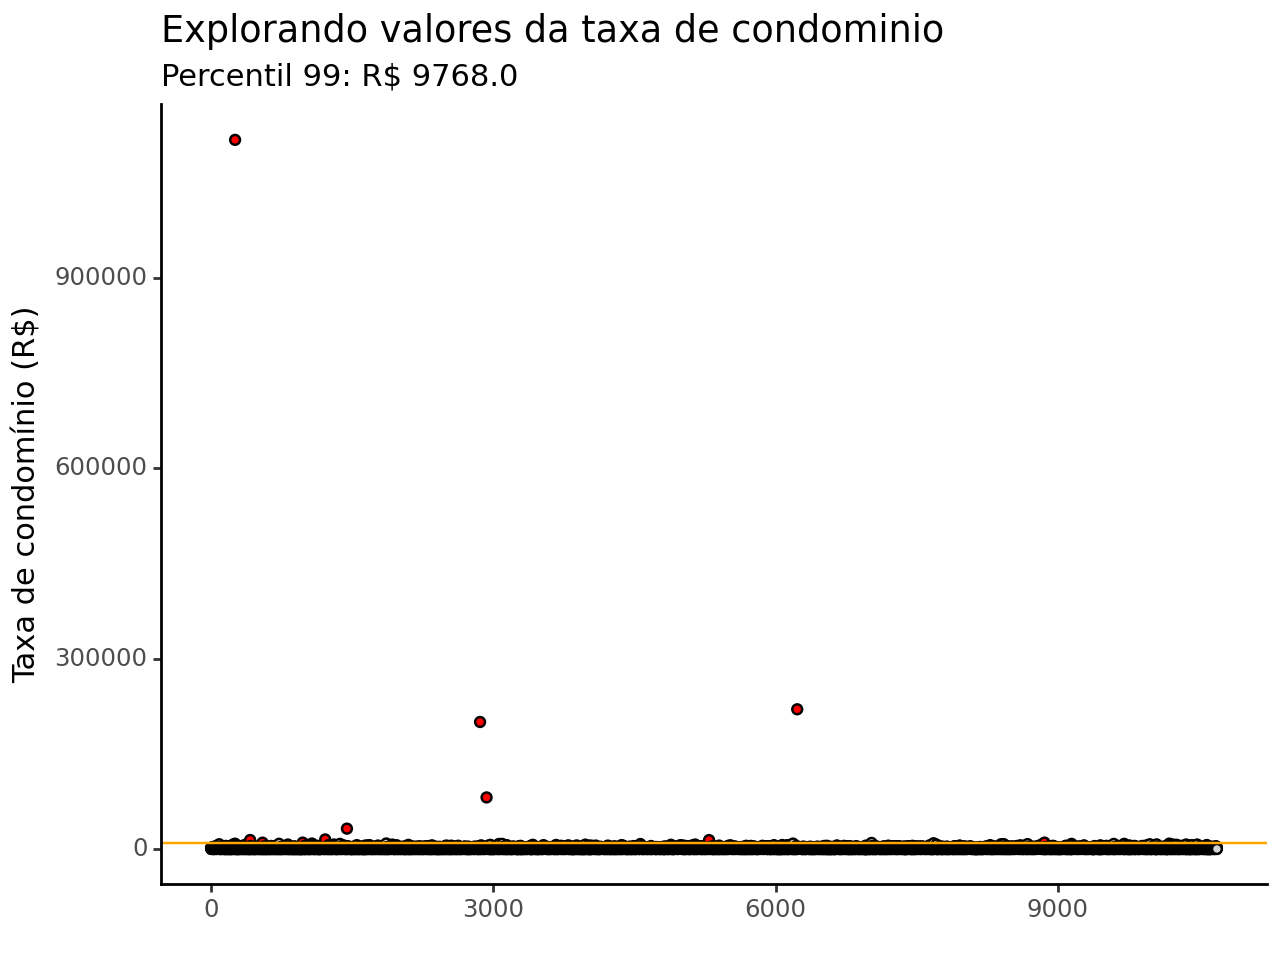

In [21]:
g=(
    ggplot(data=df)
    +geom_point(
        aes(x=df.index, y='hoa'),
        fill=['red' if dp > np.quantile(df['hoa'], .999) else 'lightgrey' for dp in df['hoa']]
    )
    +geom_hline(yintercept=np.quantile(df['hoa'], .999), color='orange')
    +theme_classic()
    +labs(
        title='Explorando valores da taxa de condominio',
        subtitle=f'Percentil 99: R$ {round(np.quantile(df["hoa"], .999), 2)}',
        y='Taxa de condomínio (R$)'
    )
)
print(g)

#### Examinando taxas de condomínio acima do percentil 99

In [22]:
percentile_99 = np.quantile(df['hoa'], .999)
df.query("hoa > @percentile_99").sort_values("hoa", ascending=False)

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,hoa,rent_amount,property_tax,fire_insurance,total
255,Belo Horizonte,155,1,4,0,4,not acept,not furnished,1117000,2790,64,38,1120000
6230,São Paulo,340,5,4,2,7,acept,not furnished,220000,12000,1000,153,233200
2859,São Paulo,285,4,5,4,6,acept,furnished,200000,20000,1834,254,222100
2928,Rio de Janeiro,35,1,1,0,1,acept,furnished,81150,4500,9900,58,95610
1444,Porto Alegre,42,1,1,0,10,acept,not furnished,32000,700,40,11,32750
1213,São Paulo,850,6,7,4,0,not acept,not furnished,15000,13000,2465,196,30660
415,São Paulo,488,4,3,3,0,acept,not furnished,14130,6400,1214,82,21820
5293,São Paulo,850,5,7,8,1,not acept,not furnished,14000,4000,0,51,18050
974,São Paulo,600,6,7,4,0,acept,furnished,10000,15000,84,226,25310
8858,São Paulo,800,4,7,8,0,not acept,not furnished,10000,8500,209,128,18840


Os registros de índices 255, 6230, 2859, 2928, 1444 apresentam, respectivamente:

1. Taxa de condomínio de mais de 1 milhão de reais;
2. Taxa de condomínio de mais de 200 mil de reais;
3. Taxa de condomínio de 200 mil de reais;
4. Taxa de condomínio desproporcional ao padrão do imóvel;
5. Taxa de condomínio desproporcional ao padrão do imóvel.

**A sugestão para tratamento desses dados é de removê-los**.

In [23]:
indexes_to_remove = df.query("hoa > @percentile_99").sort_values("hoa", ascending=False).index.values
df = df[~df.index.isin(indexes_to_remove)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10320 entries, 0 to 10691
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   city            10320 non-null  object
 1   area            10320 non-null  int64 
 2   rooms           10320 non-null  int64 
 3   bathroom        10320 non-null  int64 
 4   parking_spaces  10320 non-null  int64 
 5   floor           10320 non-null  int64 
 6   animal          10320 non-null  object
 7   furniture       10320 non-null  object
 8   hoa             10320 non-null  int64 
 9   rent_amount     10320 non-null  int64 
 10  property_tax    10320 non-null  int64 
 11  fire_insurance  10320 non-null  int64 
 12  total           10320 non-null  int64 
dtypes: int64(10), object(3)
memory usage: 1.1+ MB


#### Verificando novamente os dados de taxa de condominio, removidos os casos acima.

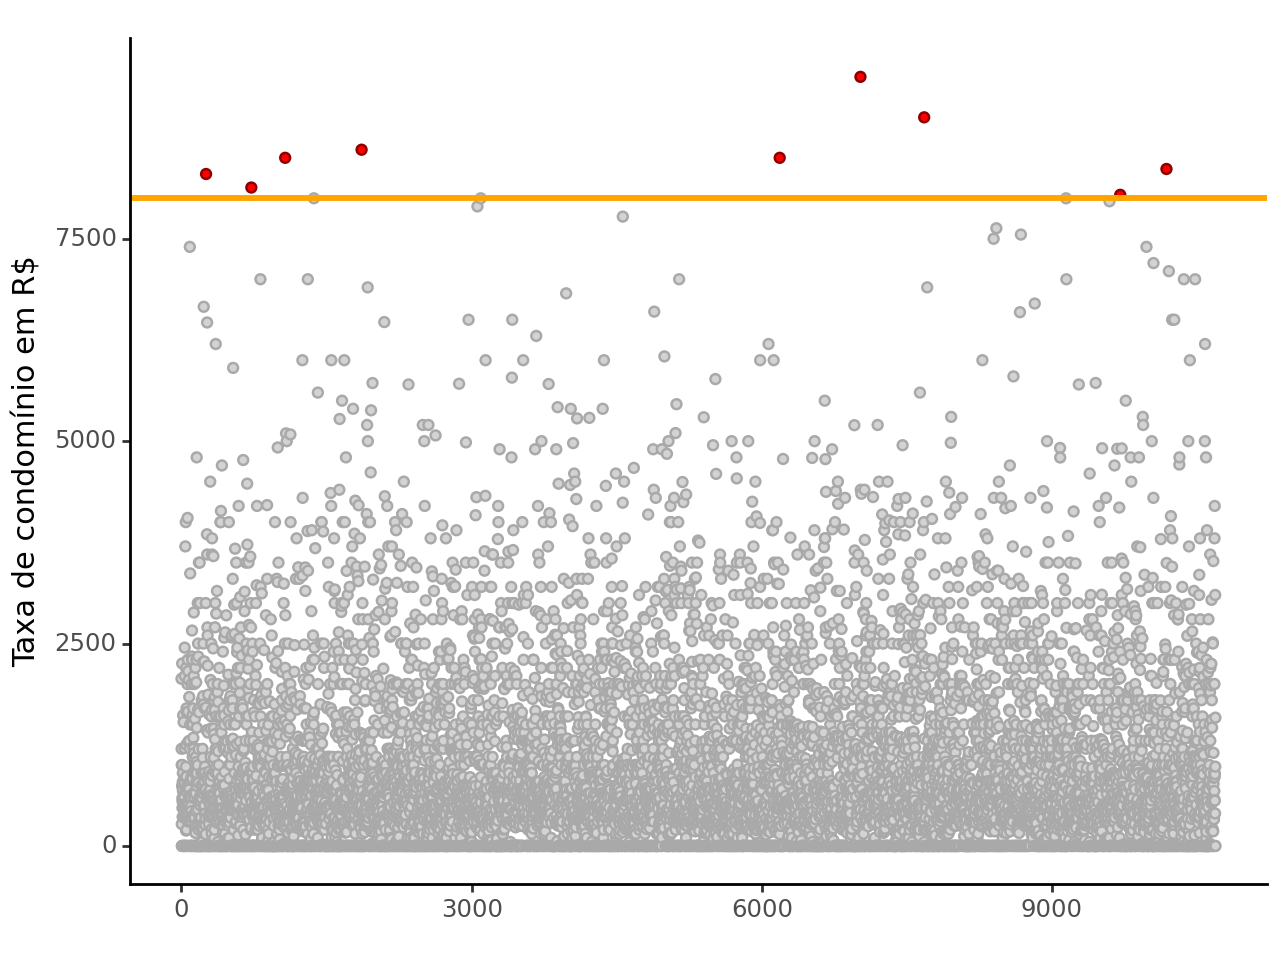

In [24]:
g=(
    ggplot(data=df)
    +geom_point(
        aes(x=df.index, y='hoa'),
        fill=['red' if dp > np.quantile(df['hoa'], .999) else 'lightgrey' for dp in df['hoa']],
        color=['darkred' if dp > np.quantile(df['hoa'], .999) else 'darkgrey' for dp in df['hoa']],
    )
    +geom_hline(yintercept=np.quantile(df['hoa'], .999), 
                color='orange',
               size=1.2)
    +theme_classic()
    +labs(
        y='Taxa de condomínio em R$'
    )
)
print(g)

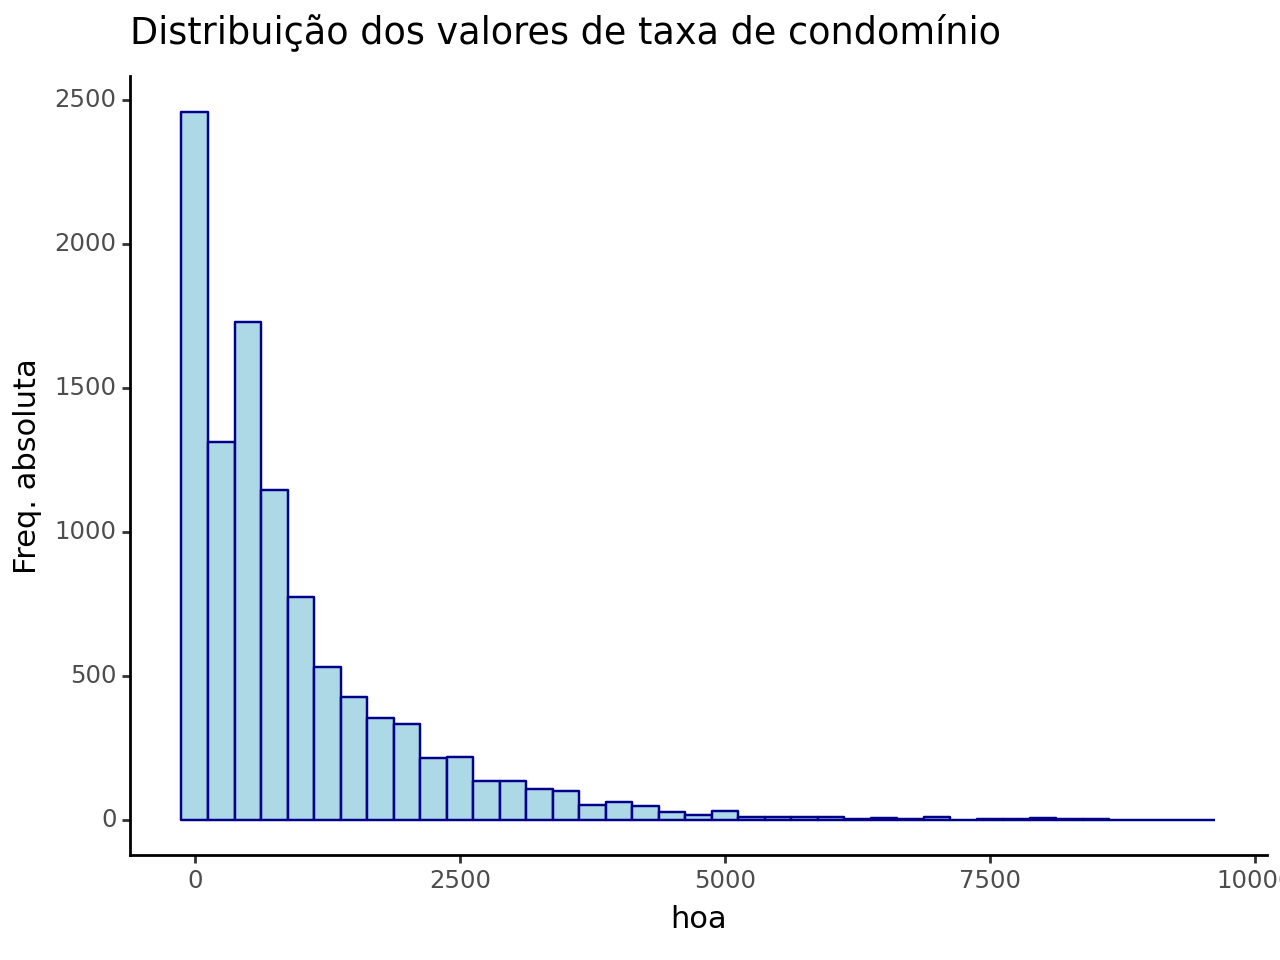

In [25]:
g=(
    ggplot(data=df)
    +geom_histogram(
        aes(x='hoa'),
        binwidth=250,
        fill='lightblue',
        color='darkblue'
    )
    +labs(
        title='Distribuição dos valores de taxa de condomínio',
        y='Freq. absoluta'
    )
    +theme_classic()
)
print(g)

#### Verificando possíveis valores discrepantes da feature *floor*

Acima vimos que há um imóvel cujo andar é 301. Precisamos verificar.

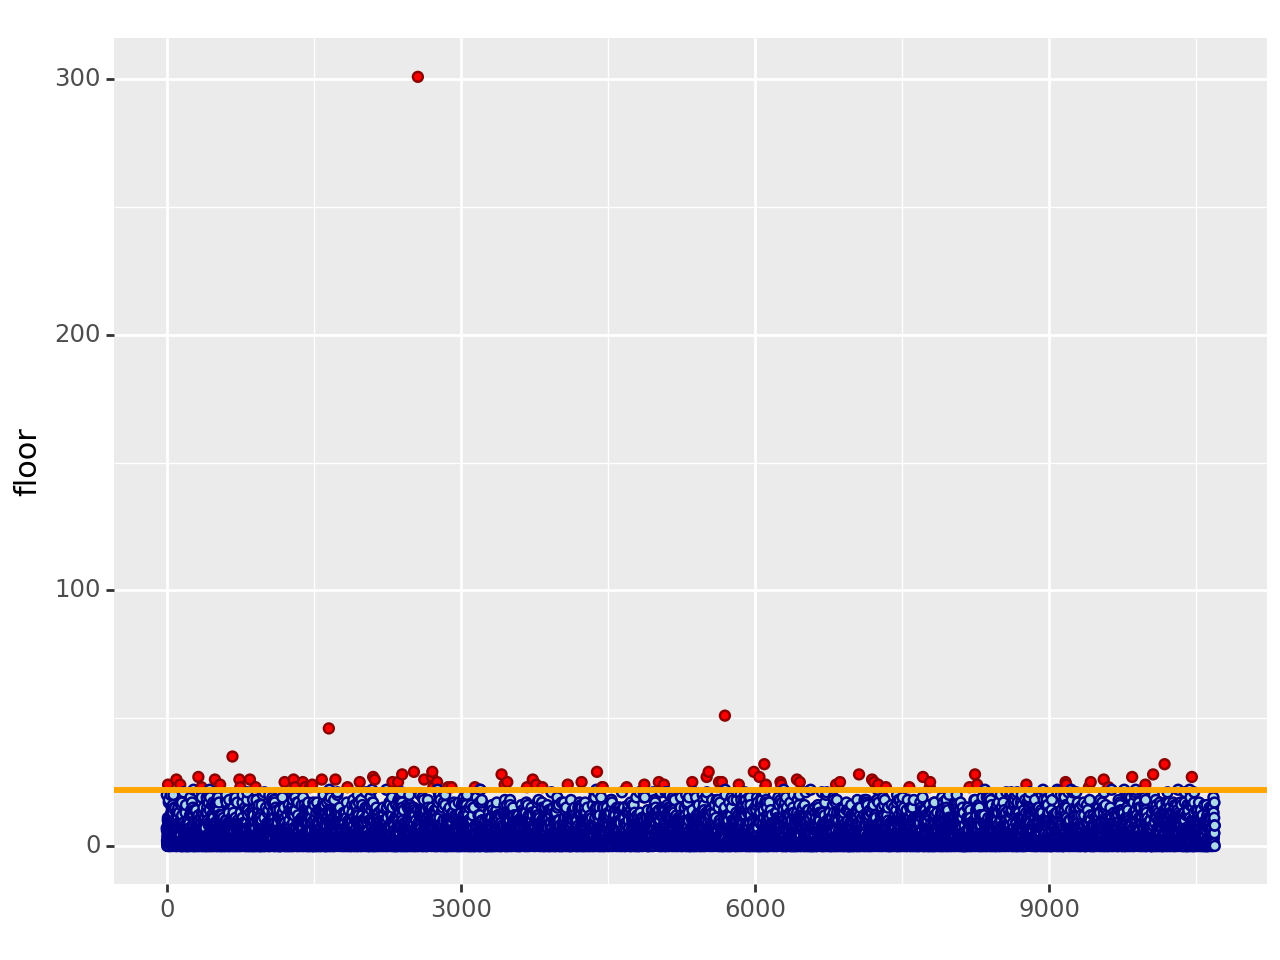

In [26]:
g=(
    ggplot(data=df)
    +geom_point(
        aes(x=df.index.values, 
            y='floor'),
        fill=['red' if c > np.quantile(df['floor'], .99) else 'lightblue' for c in df['floor']],
        color=['darkred' if c > np.quantile(df['floor'], .99) else 'darkblue' for c in df['floor']]
    )
    +geom_hline(
        yintercept=np.quantile(df['floor'], .99),
        color='orange',
        size=1.2
    )
    # +theme_classic()
)
print(g)

In [27]:
percentile_99_floor = np.quantile(df['floor'], .99)
df.loc[df['floor'] >= percentile_99_floor].sort_values('floor', ascending=False)

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,hoa,rent_amount,property_tax,fire_insurance,total
2562,Belo Horizonte,80,3,2,2,301,acept,not furnished,750,2600,164,35,3549
5694,Campinas,64,2,2,2,51,acept,not furnished,800,1900,129,25,2854
1654,São Paulo,353,4,5,5,46,acept,not furnished,3000,10000,0,127,13130
671,São Paulo,250,3,2,3,35,acept,furnished,2500,15000,1084,191,18780
6096,São Paulo,84,2,3,2,32,not acept,furnished,850,8500,450,108,9908
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6568,São Paulo,40,1,1,0,22,acept,furnished,473,2300,39,30,2842
8346,São Paulo,260,4,4,6,22,acept,furnished,2480,5500,1167,70,9217
3200,São Paulo,186,3,3,2,22,not acept,not furnished,1350,5435,405,69,7259
3197,São Paulo,225,4,5,4,22,acept,furnished,2000,9000,1192,115,12310


Evidentemente o andar 301 indicado para o imóvel em Campinas está equivocado. Já o segundo registro, em Campinas, podemos afirmar que, de acordo com [Council on Tall Buildings and Urban Habitat](https://www.skyscrapercenter.com/explore-data?output=list&types%5B%5D=building&statuses%5B%5D=COM&height=&region_id=4&country_id=22&city_id=2152&min_year=&max_year=&filter_company=&output=list), que realiza auditorias de arranha-céus pelo mundo afora, está errado. O edifício com maior número de andares localizado em Campinas, possui 38 andares.

In [28]:
# Predio com andar mais alto por cidade
def get_tallest_floor(df):
    """Returns the tallest floor by city.
    """
    cities = df['city'].unique()
    return {city: df.loc[df['city'] == city]['floor'].max() for city in cities}

In [29]:
# Validando os andares de acordo com informacoes do Council on Tall Buildings and Urban Habitat
council_data= {
    'Belo Horizonte': 42,
    'Campinas': 38,
    'São Paulo': 52,
    'Rio de Janeiro': 48,
    'Porto Alegre': 32
}

def validate_tallest_floor(data:dict, info:dict) -> dict:
    """Checks if the data of floors by city is less than or equal to the database

    Args:
        data (dict): Tallest floor from the DataFrame
        info (dict): Database to be compared with.
    
    Returns:
        dict
    """
    return {k:True if data[k] <= info[k] else False for k in data.keys()}  

In [30]:
validated_data = validate_tallest_floor(get_tallest_floor(df), council_data)
validated_data

{'São Paulo': True,
 'Porto Alegre': True,
 'Rio de Janeiro': True,
 'Campinas': False,
 'Belo Horizonte': False}

In [31]:
# Encontrar os registros para removê-los

campinas_condition= "city == 'Campinas' and floor > @council_data['Campinas']"
bh_condition= "city == 'Belo Horizonte' and floor > @council_data['Belo Horizonte']"

conditions = [campinas_condition, bh_condition]


# Converter a coluna 'floor' para o tipo de dado int
df['floor'] = df['floor'].astype(int)

def drop_by_indexes(df: pd.DataFrame, conditions: list | np.ndarray):
    for condition in conditions:
        indexes = df.query(condition).index
        df = df.drop(indexes)
    
    return df

C:\Users\doroc\AppData\Local\Temp\ipykernel_10836\2308584724.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [32]:
df = drop_by_indexes(df,conditions)

In [33]:
print(type(conditions[0]))

<class 'str'>


In [34]:
df.floor.max()

46

#### Explorando os valores de IPTU: R$ 313.700

De acordo com o site [serasa](https://www.serasa.com.br/blog/iptu-o-que-e-quem-tem-que-pagar/), existem alguns fatores que influenciam o valor do IPTU a ser pago. Esse imposto é calculado com base no valor venal do imóvel.

<cite>Alguns fatores influenciam o valor venal do imóvel, como: 
- o tamanho do terreno;
- a localização;
- a área construída e;
- o tipo de acabamento.

A base de cálculo usa essas informações para depois multiplicar o valor venal pela alíquota que cada município estabelece para o IPTU.<cite/>

Existem legislações específicas que isentam o pagamento de IPTU. Essas legislações são de competência dos municípios.

Veja exemplos [aqui.](https://economia.uol.com.br/noticias/redacao/2023/02/08/iptu-entenda-quando-imoveis-sao-isentos-da-cobranca-de-imposto-em-sp-e-rj.htm#:~:text=Em%20S%C3%A3o%20Paulo%2C%20s%C3%A3o%20isentos%20de%20IPTU%20os%20seguintes%20im%C3%B3veis%3A&text=Que%20sirvam%20como%20resid%C3%AAncia%2C%20de,%C3%A0%20Uni%C3%A3o%20para%20fins%20educacionais.)

In [35]:
df[df['property_tax'] > 1.5*scipy.stats.iqr(df['property_tax'])].sort_values('property_tax', ascending=False)

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,hoa,rent_amount,property_tax,fire_insurance,total
6645,São Paulo,42,1,2,1,6,not acept,not furnished,690,2500,313700,32,316900
6243,Rio de Janeiro,95,2,2,1,11,acept,not furnished,1024,3000,28120,39,32180
1699,São Paulo,700,4,4,4,0,acept,not furnished,0,10000,21880,151,32040
10172,Belo Horizonte,260,4,4,6,10,acept,furnished,3200,11900,12500,159,27760
5331,São Paulo,300,4,5,5,6,not acept,not furnished,3500,1990,10830,26,16350
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7921,Campinas,326,3,3,4,0,acept,not furnished,870,4200,523,64,5657
2435,São Paulo,108,2,4,2,7,acept,not furnished,1289,4500,522,58,6369
1415,Belo Horizonte,150,4,4,4,12,acept,not furnished,890,4200,522,56,5668
5255,Belo Horizonte,373,4,5,7,0,acept,not furnished,0,11500,522,189,12210


Conforme vemos acima, temos dois pontos importantes a serem trabalhados:

1. O primeiro registro deve ser excluído. Não faz sentido um imóvel de 42 $m^2$ ter um IPTU de R$ 313.700
2. Alguns dos demais registros nos levantam a suspeita de que sejam valores anuais em vez de mensais. Mas, a partir de qual valor devemos considerar que se trata de um valor anual e não mensal?

Para tentar responder a questão 2:

- Classificaremos os imóveis de acordo com o tamanho da área;
- Verificamos o valor mediano de IPTU de cada grupo e multiplicaremos por 12 para anualizar. Chamaremos de *mediana anualizada*;
- Existem, eventualmente, valores iguais ou superiores à mediana anualizada. Faria sentido dividi-los por 12. Porém, exsitem valores que se aproximam da mediana anualizada, mas ainda são inferiores. Nesse caso, não são alterados.

In [36]:
# Excluindo o registro de IPTU R$ 313.700
df = df[~df.index.isin([6645])]

In [37]:
df.groupby(['city'])['area'].agg(['min', 'max'])

,min,max
city,,
Belo Horizonte,15,2000
Campinas,20,999
Porto Alegre,18,981
Rio de Janeiro,15,950
São Paulo,11,1600


In [38]:
def create_area_category(series:pd.Series) -> str:
    """Return respective category depending on the area
    Args:
        series (pd.Series): Pandas Series with area values
    Returns:
        pd.Series
    """
    
    if series <= 50:
        return "ate 50"
    elif series >= 51 and series <= 100:
        return "51 a 100"
    elif series >= 101 and series <= 150:
        return "101 a 150"
    elif series >= 151 and series <= 200:
        return "151 a 200"
    elif series >= 201 and series <= 250:
        return "201 a 250"
    elif series >= 251 and series <= 300:
        return "251 a 300"
    elif series >= 301 and series <= 350:
        return "301 a 350"
    elif series >= 351 and series <= 400:
        return "351 a 400"
    elif series >= 401 and series <= 450:
        return "401 a 450"
    elif series >= 451 and series <= 500:
        return "451 a 500"
    else:
        return ">500"

In [39]:
df = df.assign(area_category=lambda x: x['area'].apply(create_area_category))

In [40]:
df.groupby(['city', 'area_category'])['property_tax'].agg(['min','mean', 'median', 'max'])

min         mean  median    max
city           area_category                                 
Belo Horizonte 101 a 150        0   232.493827   193.5   1500
               151 a 200        0   328.978571   259.0   1058
               201 a 250        0   502.460526   324.0   1900
               251 a 300        0   575.409639   379.0  12500
               301 a 350        0   582.959184   417.0   2241
               351 a 400        0   474.666667   404.0   1975
               401 a 450        0   502.434783   466.0   2192
               451 a 500        0   533.888889   460.0   1297
               51 a 100         0   107.854722    85.0   1680
               >500             1   907.979167   820.5   3000
               ate 50           0    58.456376    39.0    334
Campinas       101 a 150        0   163.137255   135.5   1056
               151 a 200        0   213.769231   200.5    600
               201 a 250        0   336.305556   327.0    715
               251 a 300        0   372.387097   366.0   1167
               301 a 350       55   409.736842   407.0    673
               351 a 400      269   565.222222   534.0    888
               401 a 450      230   513.800000   445.5    880
               451 a 500       82   685.500000   674.0   1080
               51 a 100         0    74.876011    64.0   1500
               >500           200   833.052632   817.0   1898
               ate 50           0    34.524390    20.5    277
Porto Alegre   101 a 150        0   192.584507   142.0   2500
               151 a 200        0   220.824561   175.0   1300
               201 a 250        0   364.972222   317.5   2360
               251 a 300        0   219.115385   206.5    500
               301 a 350       34   573.375000   367.0   2900
               351 a 400        0   400.187500   315.0   1100
               401 a 450       84   303.363636   197.0    959
               451 a 500       38   581.333333   381.5   1250
               51 a 100         0    74.872763    54.0   2610
               >500             0   853.500000   521.0   4500
               ate 50           0    38.912500    25.0    658
Rio de Janeiro 101 a 150        0   292.151020   250.0   2731
               151 a 200        0   483.035088   383.0   5404
               201 a 250        0   549.617647   500.0   1839
               251 a 300       14   836.666667   750.0   3334
               301 a 350      190   674.666667   682.0   1084
               351 a 400        6   926.727273   750.0   2500
               401 a 450      417   917.900000   829.5   1649
               451 a 500       54   795.000000   486.0   1650
               51 a 100         0   194.841244   109.0  28120
               >500           334  1384.769231  1250.0   4241
               ate 50           0    59.710366    49.5    593
São Paulo      101 a 150        0   302.800738   265.0   4000
               151 a 200        0   507.211111   459.0   4710
               201 a 250        0   747.131373   717.0   5000
               251 a 300        0   894.756374   800.0  10830
               301 a 350        0  1100.014851   996.0   3461
               351 a 400        0  1266.818653  1142.0   4830
               401 a 450        0  1311.044776  1250.0   3700
               451 a 500        0  1568.038961  1230.0   5500
               51 a 100         0   125.618215    84.0   3000
               >500             0  2610.782609  2106.0  21880
               ate 50           0    62.939962    34.0   4247

In [41]:
df=df.assign(monthly_property_tax=np.where(df['property_tax'] >= df.groupby(['city', 'area_category'])['property_tax'].transform(lambda x: np.median(x)*12), df['property_tax']/12, df['property_tax']),
            area_category_property_tax_median=df.groupby(['city', 'area_category'])['property_tax'].transform(lambda x: np.median(x)))

In [42]:
df = df[['city', 'area', 'area_category', 'rooms', 'bathroom', 'parking_spaces', 'floor', 'animal', 'furniture', 'hoa', 'rent_amount', 'property_tax', 'area_category_property_tax_median', 'monthly_property_tax','fire_insurance', 'total']].copy()

## PERGUNTAS DUPLA 3

- Existe uma relação entre a área (m²) e o fato do apartamento aceitar animais de estimação ou não? 
- O andar do apartamento influencia no preço do m² do apartamento? Como isso se comporta entre as cidades analisadas? 
- Qual a proporção entre o custo dos aluguéis mensais (custo total) e o salário mínimo, por cidade analisada?

#### A Relação entre área e animais de estimação existe?

Vou começar fazendo uma breve análise descritica de ambas variáveis

count    10317.000000
mean       144.075313
std        134.732285
min         11.000000
25%         59.000000
50%         95.000000
75%        190.000000
max       2000.000000
Name: area, dtype: float64


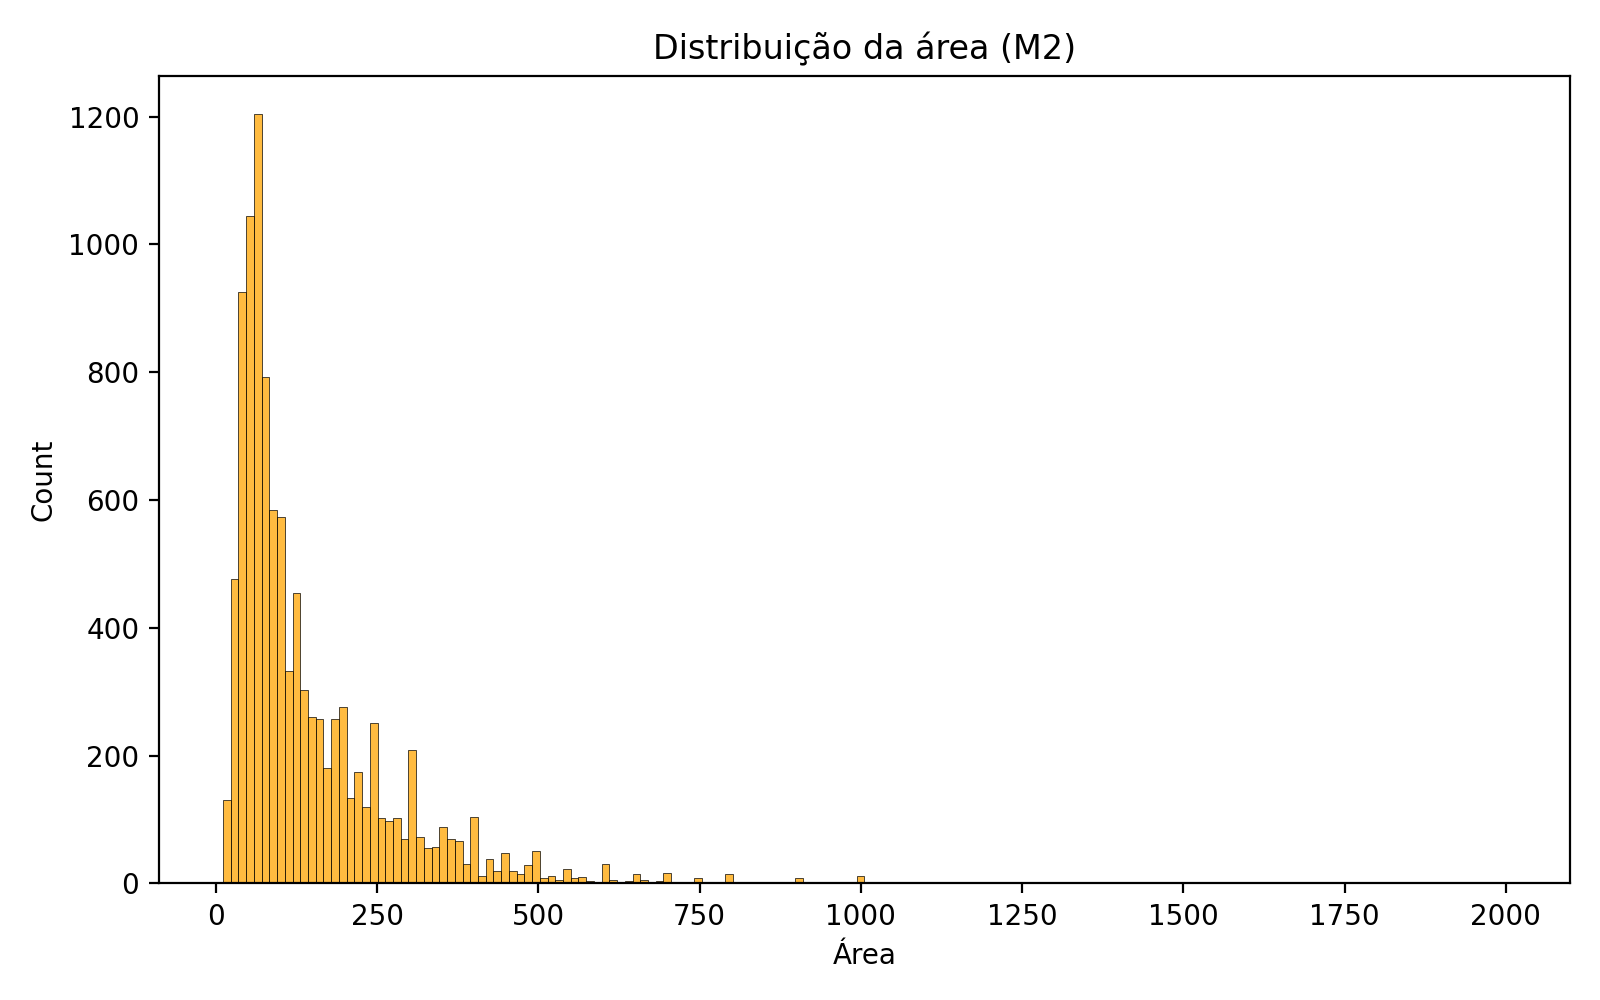

In [43]:
#ÁREA
 
print(df['area'].describe())

plt.figure(figsize=(8,5))
sns.histplot(df['area'], color = 'orange')
plt.title("Distribuição da área (M2)")
plt.xlabel("Área")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

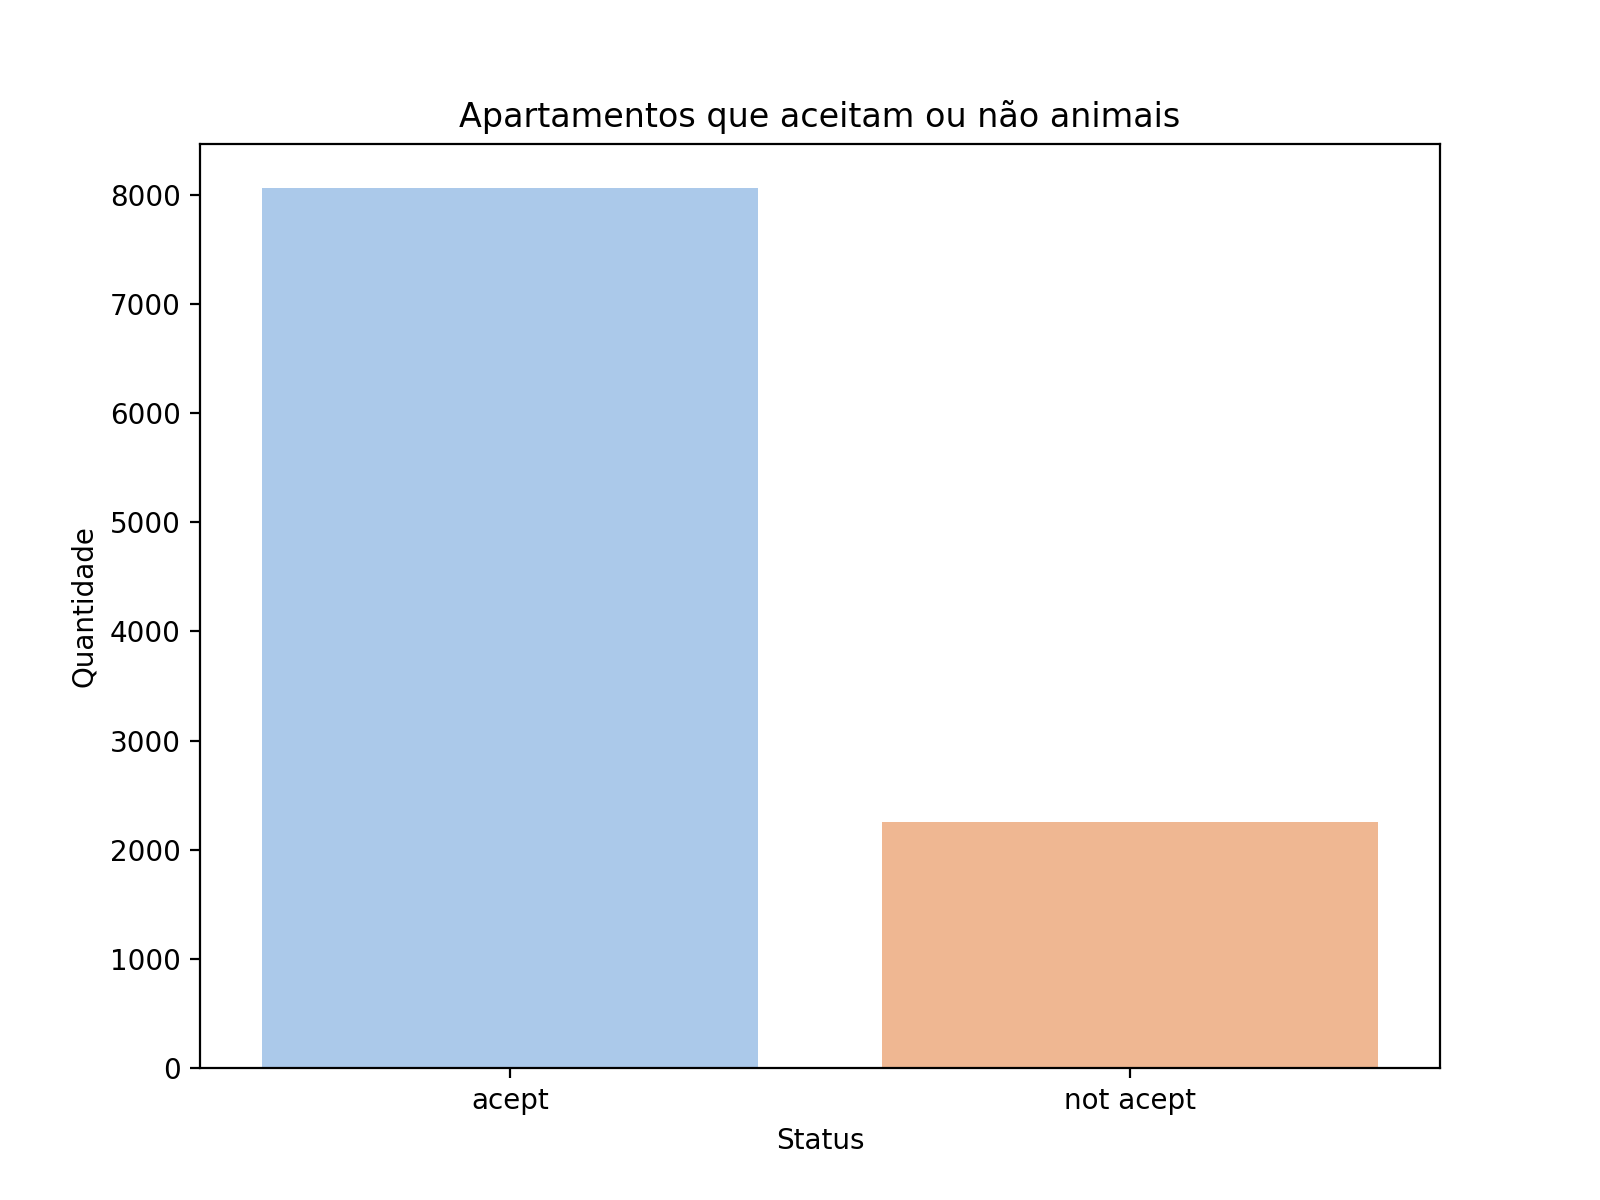

In [44]:
# ANIMAIS

df['animal'].value_counts().reset_index()
plt.figure(figsize=(8,6))
sns.barplot(x='animal', y='count', data = df['animal'].value_counts().reset_index(), hue='animal', palette='pastel')
plt.title("Apartamentos que aceitam ou não animais")
plt.xlabel("Status")
plt.ylabel("Quantidade")
plt.show()

- Hipótese gerada : Casas com área maior são as que mais aceitam animais? 

        - Hipótese nula (H0): μ1 = μ2 (Não há diferença significativa nas médias da área entre os grupos de apartamentos que aceitam e não aceitam animais, onde μ1 representa a média da área nos apartamentos que aceitam animais e μ2 representa a média da área nos apartamentos que não aceitam animais).

        - Hipótese alternativa (H1): μ1 ≠ μ2 (Há uma diferença significativa nas médias da área entre os grupos de apartamentos que aceitam e não aceitam animais).
        
- Teste de hipótese : Análise t de amostras independentes

In [45]:
# Dividir os valores dos grupos que aceitam ou não animais
df_animal_area = df[['animal','area']].copy().sort_values(by='animal')
area_acept = df_animal_area[df_animal_area['animal'] == 'acept'].copy()
area_noacept = df_animal_area[df_animal_area['animal'] == 'not acept'].copy()

# TESTE T DE VARIÁVEIS INDEPENDENTES
t_statistic, p_value = stats.ttest_ind(area_acept['area'], area_noacept['area'])

print("Estatística t:", t_statistic)
print("Valor-p:", p_value)

if p_value < 0.05:
    print("Há evidências para rejeitar a hipótese nula.")
else:
    print("Não há evidências para rejeitar a hipótese nula.")

Estatística t: 13.075364942008065
Valor-p: 9.251853411925359e-39
Há evidências para rejeitar a hipótese nula.


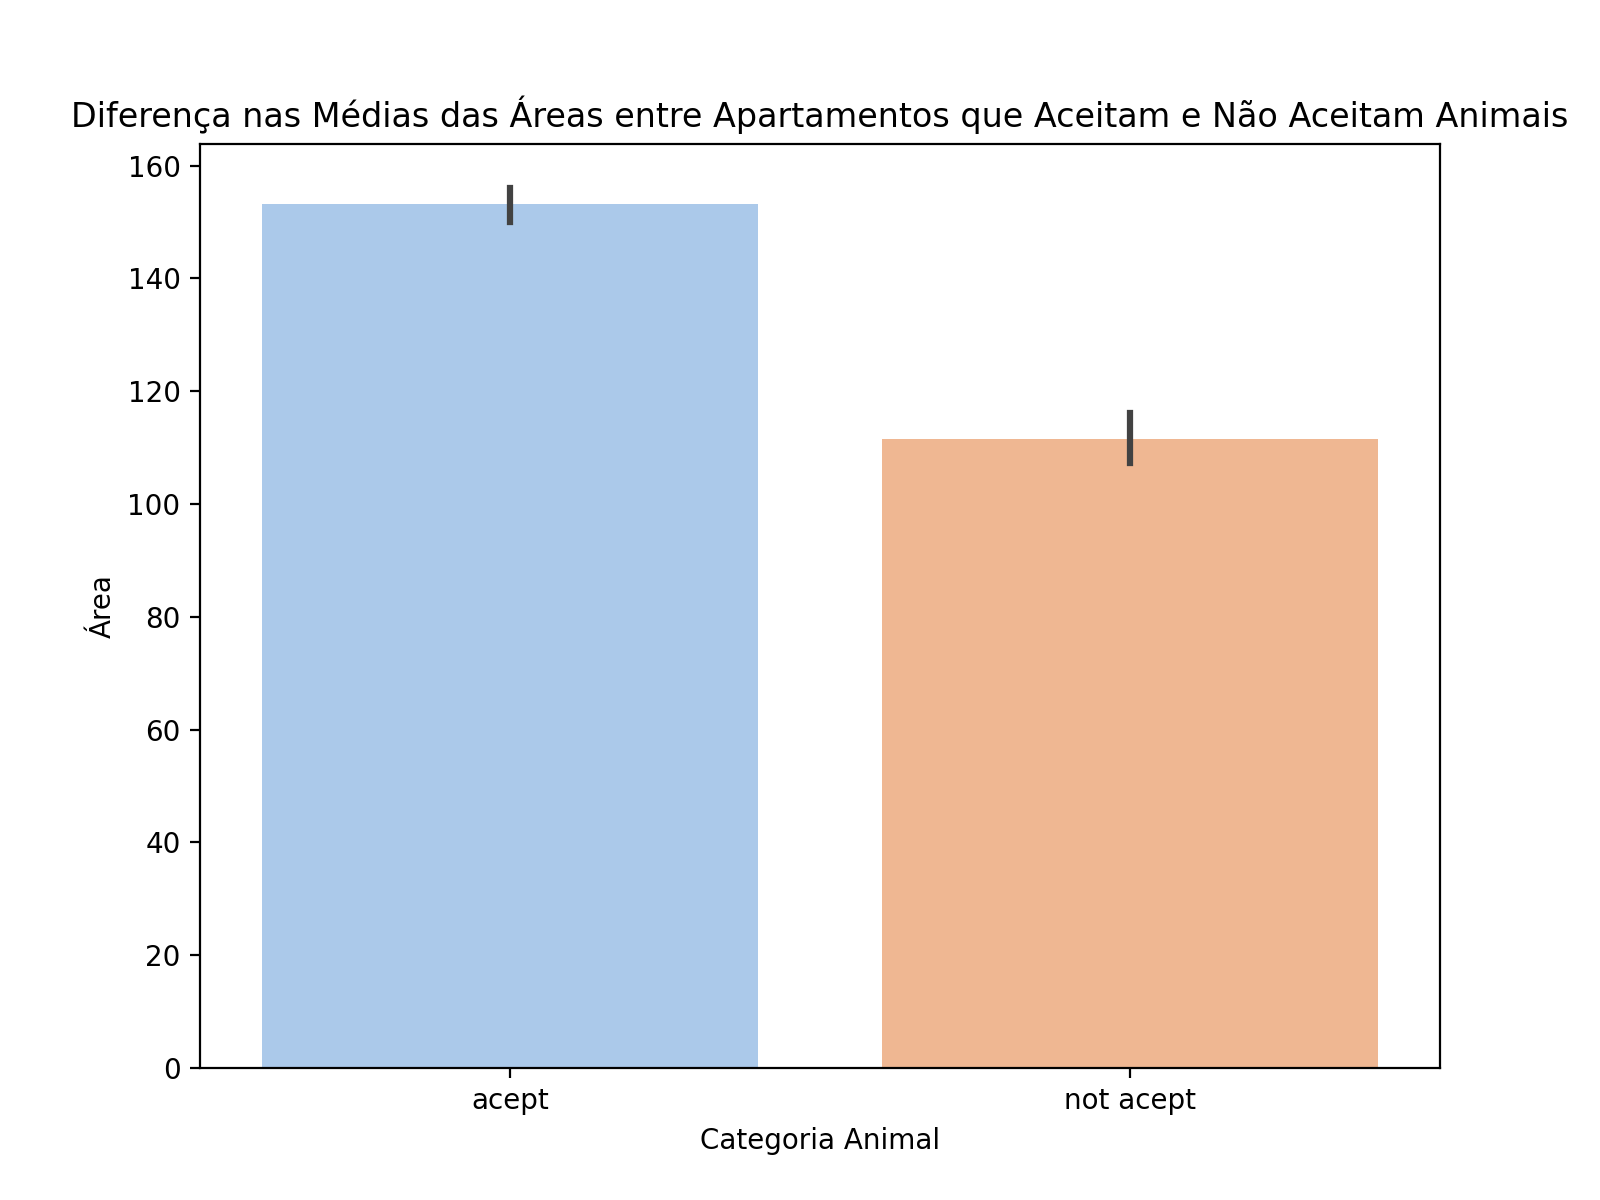

In [46]:
# VISUALIZAÇÃO GRÁFICA DAS MÉDIAS
plt.figure(figsize=(8, 6))
sns.barplot(x='animal', y='area', data=df_animal_area, hue='animal', palette='pastel')
plt.title('Diferença nas Médias das Áreas entre Apartamentos que Aceitam e Não Aceitam Animais')
plt.xlabel('Categoria Animal')
plt.ylabel('Área')
plt.show()

Portanto:
- A estatística t (13.28) indica que existe uma diferença substancial nas médias das áreas entre os dois grupos.
- O valor-p (quase zero) indica que essa diferença nas médias não é devida ao acaso; é altamente improvável que tenha ocorrido por acaso.

Para visualizar a diferença entre as duas médias, plotei o gráfico acima

#### O andar do apartamento influencia no preço do m² do apartamento? Como isso se comporta entre as cidades analisadas?

In [47]:
# PREÇO DO M² (Considerando o valor de mercado!)
df['preco/m2'] = round(df['rent_amount'] / df['area'],2)

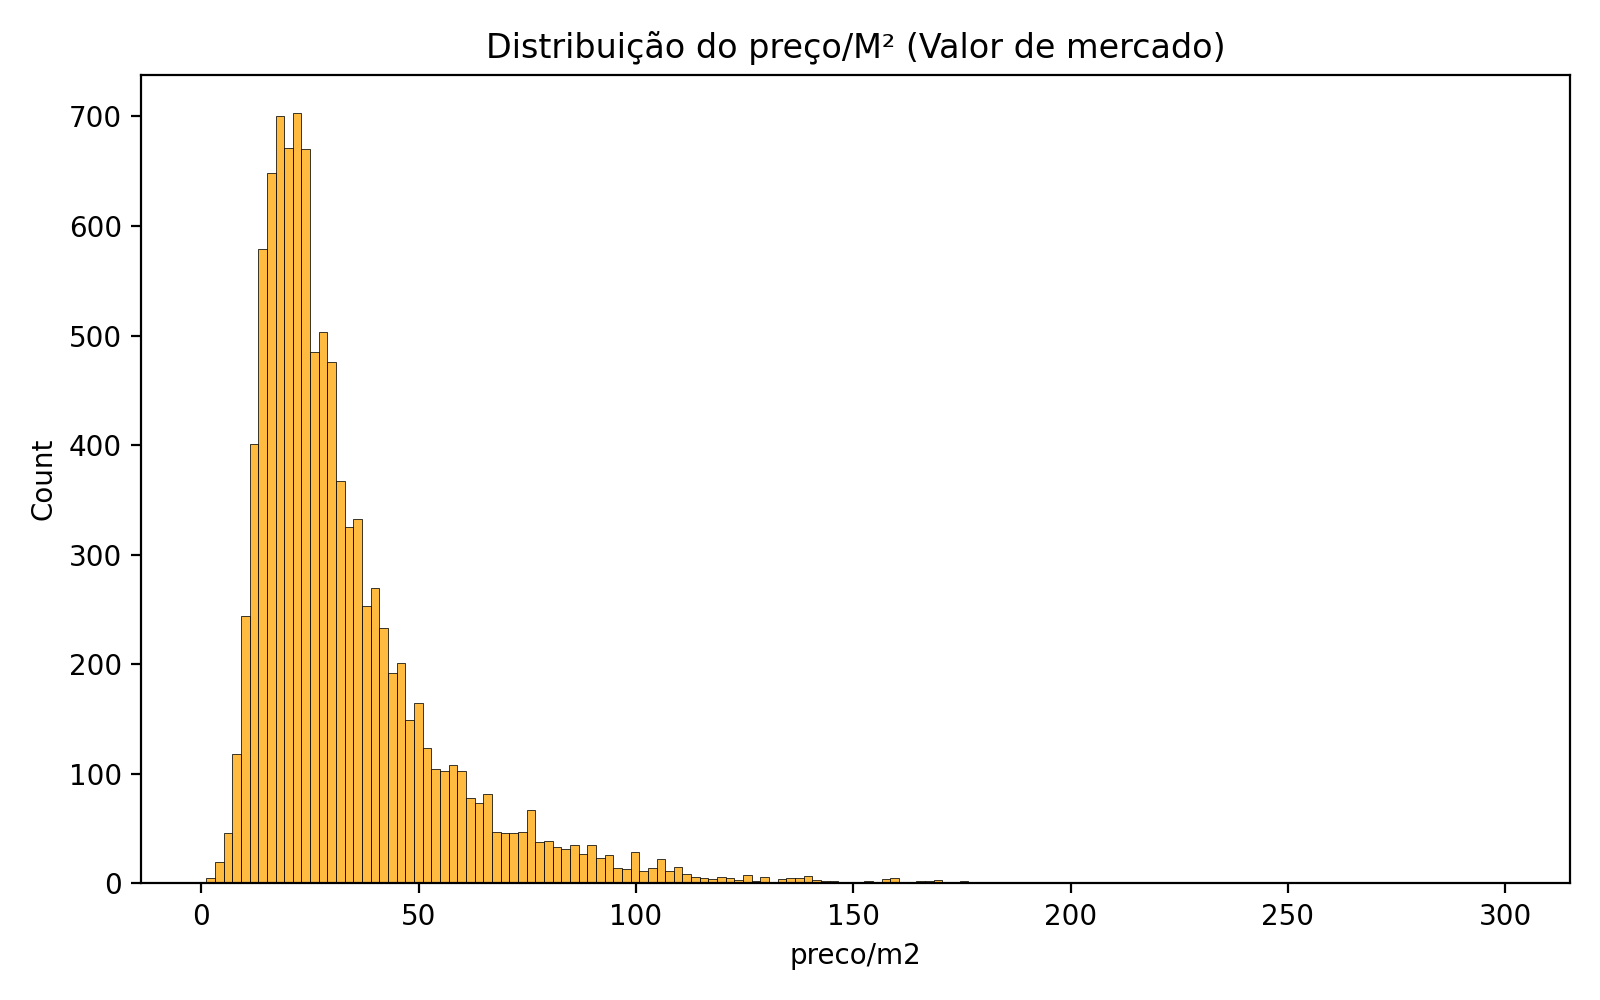

In [48]:
# DISTRIBUIÇÃO DO PREÇO/M2
plt.figure(figsize=(8,5))
sns.histplot(df['preco/m2'], color = 'orange')
plt.title("Distribuição do preço/M² (Valor de mercado)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

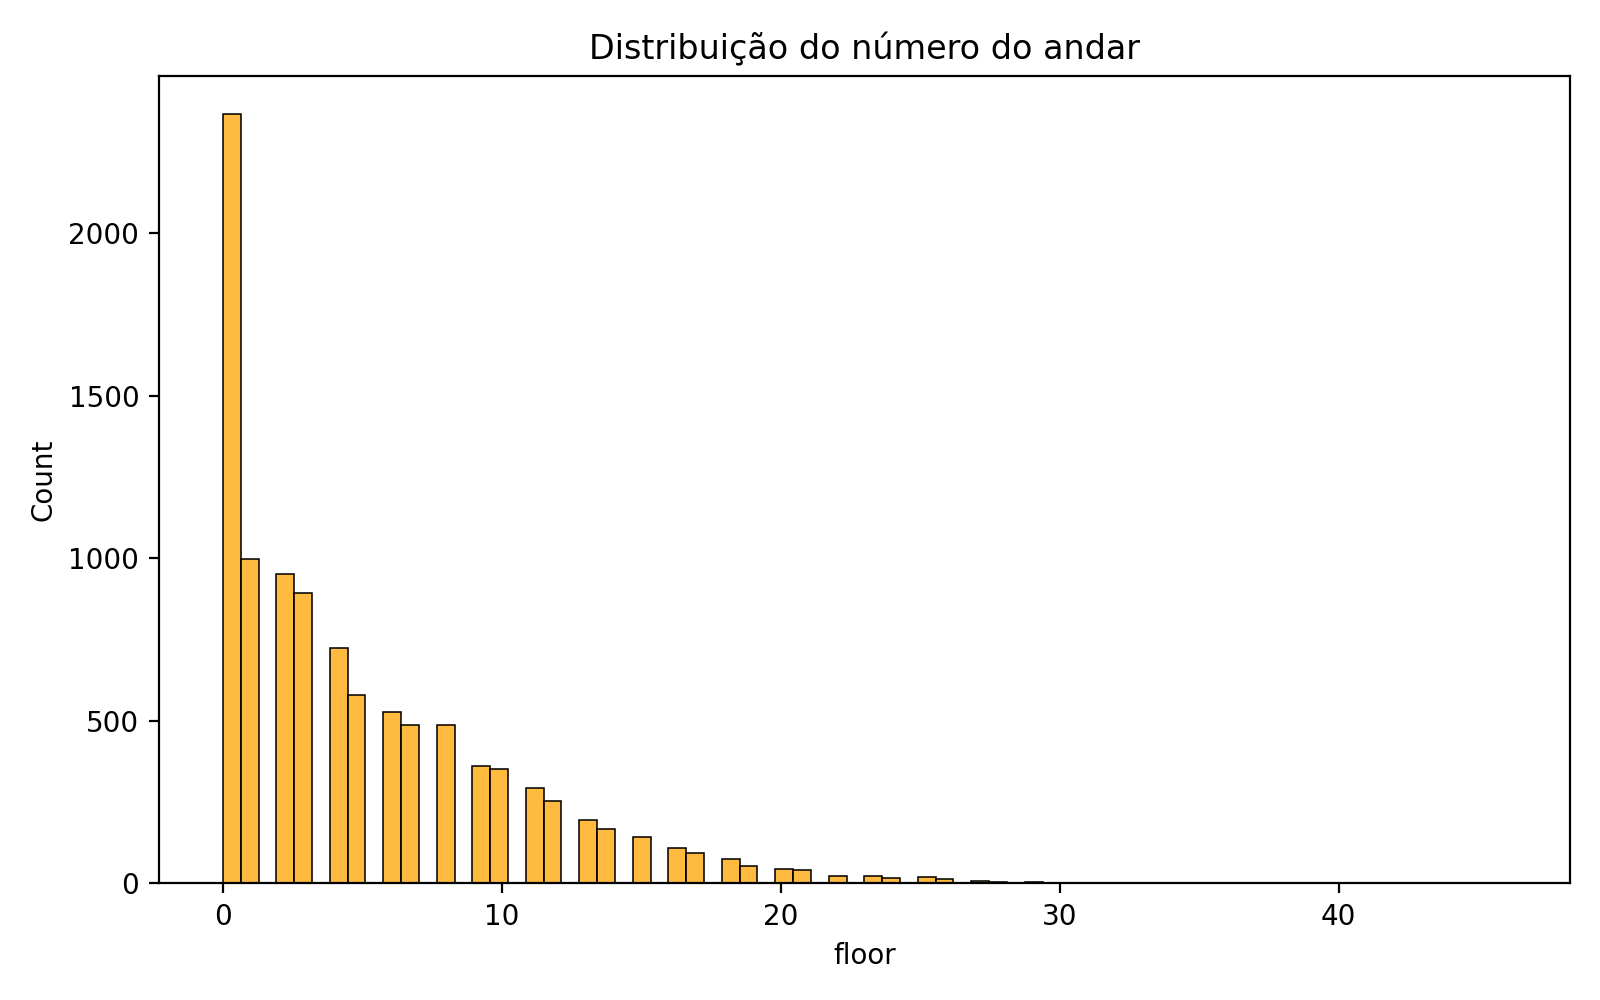

In [49]:
# Distribuição dos andares
plt.figure(figsize=(8,5))
sns.histplot(df['floor'], color = 'orange')
plt.title("Distribuição do número do andar")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Após a análise das distribuições, foi utilizado o método da correlação de Pearson para estimar a relação entre estas variáveis.

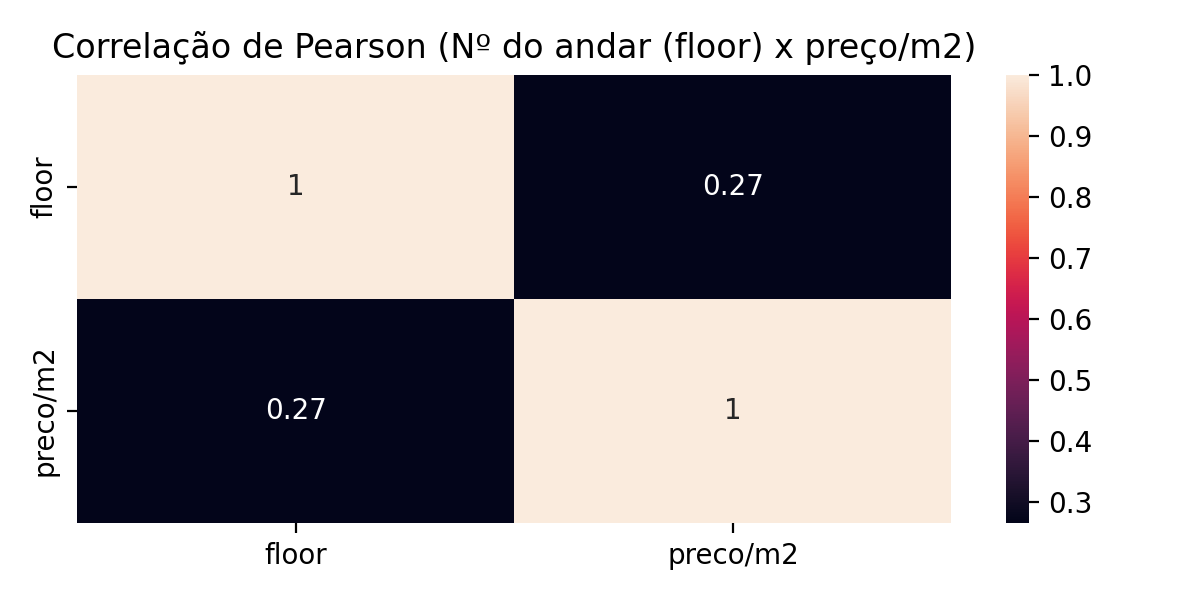

In [50]:
plt.figure(figsize=(6,3))
sns.heatmap(df[['floor', 'preco/m2']].corr(), annot=True)
plt.title('Correlação de Pearson (Nº do andar (floor) x preço/m2)')
plt.tight_layout()
plt.show()

- Portanto:
A correlação de 0.27 entre as variáveis sugere uma Correlação Positiva Fraca entre o número de andares e o preço/m² do apartamento, isto indica que, em média, quando uma variável aumenta, a outra tende a aumentar, mas a relação não é forte. Pode haver muita variação nos dados que não é explicada por essa correlação.



####
Agora para cada cidade análisada se fará a mesma análise

In [51]:
# DIVISÃO DOS DADOS POR CIDADE
df_cam = df[df['city'] == 'Campinas']
df_sp = df[df['city'] == 'São Paulo']
df_rj = df[df['city'] == 'Rio de Janeiro']
df_bh = df[df['city'] == 'Belo Horizonte']

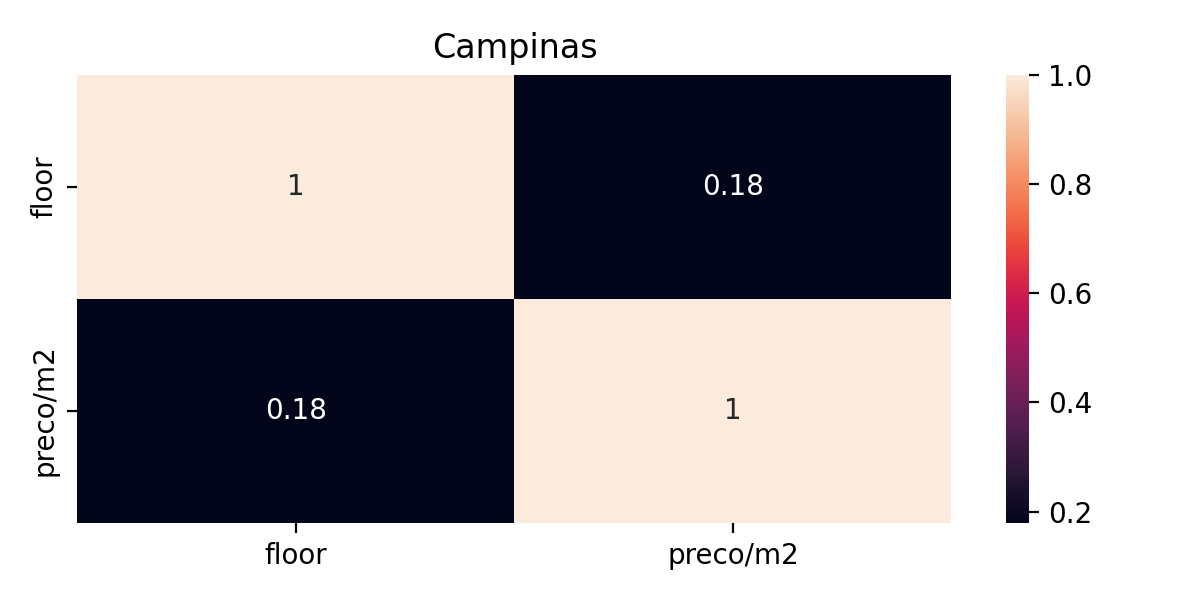

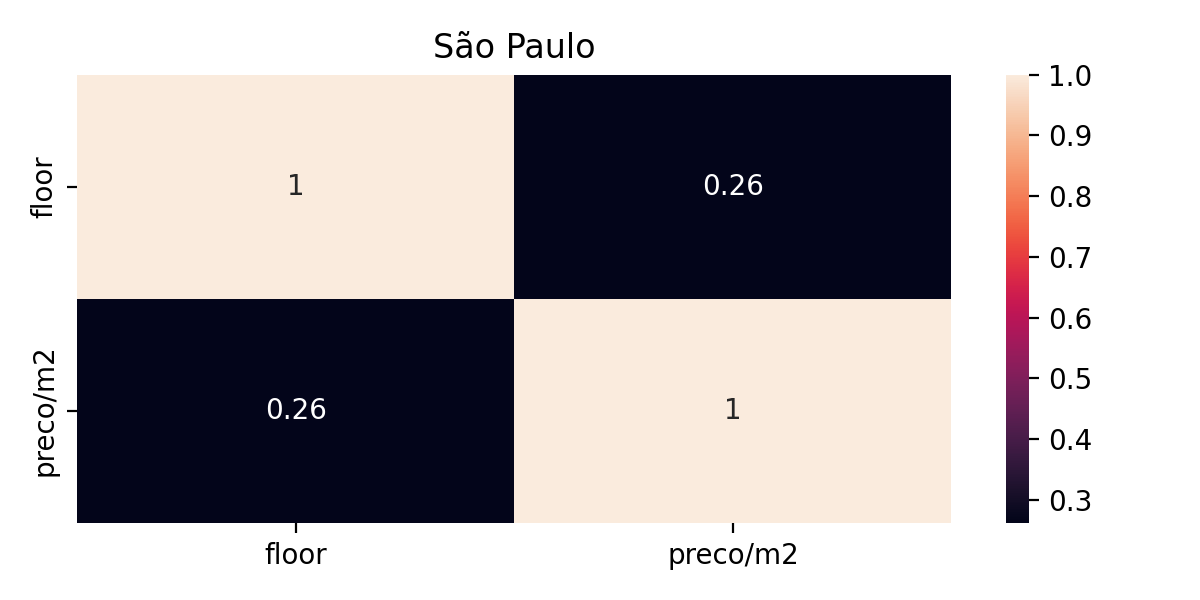

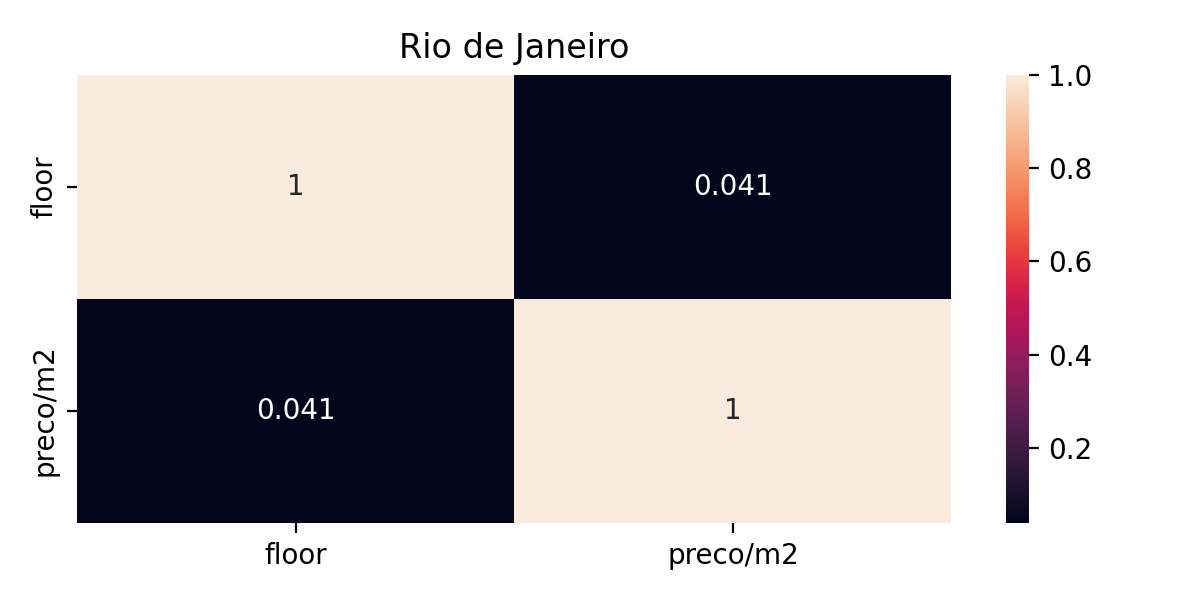

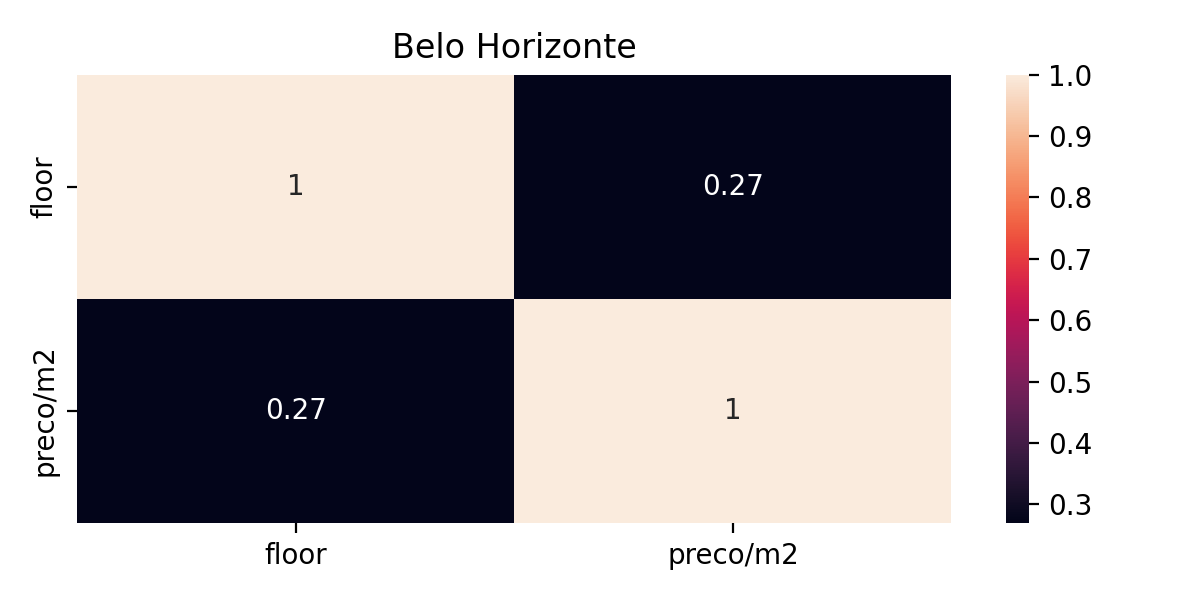

In [52]:
# Correlação de pearson em todas cidades

lista = [df_cam, df_sp, df_rj, df_bh]
cidades = ['Campinas', 'São Paulo', 'Rio de Janeiro', 'Belo Horizonte']

for data, cidade in zip(lista, cidades):
    plt.figure(figsize=(6, 3))
    sns.heatmap(data[['floor', 'preco/m2']].corr(), annot=True)
    plt.title(cidade)
    plt.tight_layout()
    plt.show()
    

Portanto:
- A cidade do Rio de Janeiro possui a menor correlação entre número do andar e preço/m², com valor muito próximo de 0;
- São Paulo e BH possuem correlação semelhante a população total;
- Campinas possui correlação fraca, mas está abaixo da observada em SP e BH.
- Ou seja, o número do andar está mais relacionado ao preço/m2 em BH e SP do que nas demais cidades